In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA
from sklearn.metrics import silhouette_score

# import sys # the basemap visualisation raises future warnings from matplotlib
# import warnings 
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")

### Import and Prep Data

In [126]:
# df = pd.read_csv("datafiles/ids.csv")
# masks = [abs(hash(str(val))) for val in df['id']]
# df['id'] = masks
# df.to_csv("datafiles/hashed_ids.csv", index = False)

df = pd.read_csv("datafiles/hashed_ids.csv")

# explode() doesn't work without these manipulations, though it really should
df['games_played'] = df['games_played'].str.replace("'","")
df['games_played'] = df['games_played'].str.replace("[","")
df['games_played'] = df['games_played'].str.replace("]","")
df['games_played'] = df['games_played'].str.split(",")

df = df.explode('games_played')
df.columns = ['user', 'game']

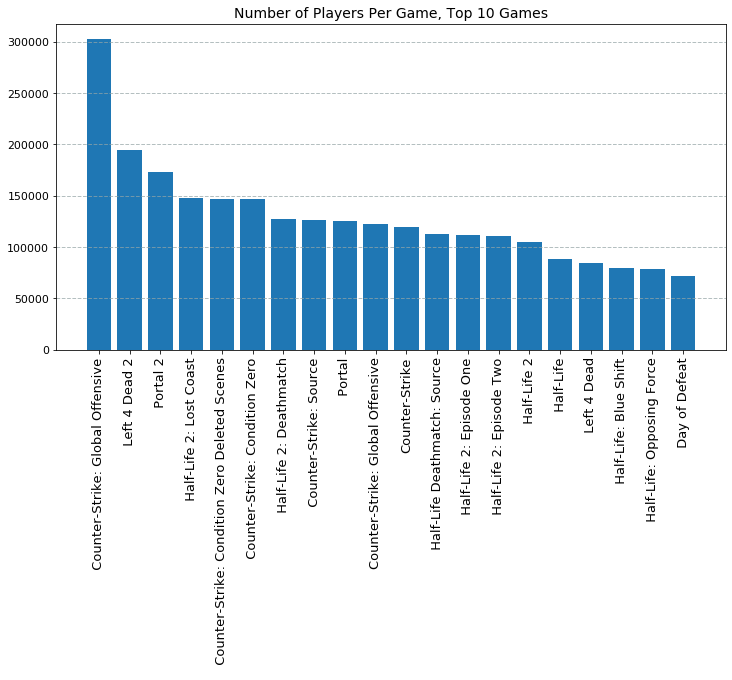

In [128]:
# what are the top games?
gamecount = pd.DataFrame(df.groupby('game')['user'].count())
gamecount = gamecount.reset_index()
gamecount.columns = ['game', 'num_players']
gamecount = gamecount.sort_values('num_players', ascending = False)

fig, ax = plt.subplots(figsize = (12,6))
ax.bar(gamecount['game'][:20],gamecount['num_players'][:20])
ax.set_title("Number of Players Per Game, Top 10 Games", size = 14)
plt.yticks(size = 11)
plt.xticks(rotation = 90, size = 13)
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)# plt.figure(num = 'top games', figsize = (24,6))
# sns.barplot(x = games['game'][:11], y = games['hours'][:11]);
plt.show()

### find optimal number of clusters

In [181]:
# now the games will be the columns, and a 1 will indicate the user played that game
matrix = df.pivot(index = 'user', columns = 'game', values = 'user') # this is returning the user id as the value in the cell
matrix = matrix / matrix # feels hacky - converts cell values to 1, by dividing the user id by itself. is this terrible or amazing?
matrix.head()

game,,Counter-Strike,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero Deleted Scenes,Counter-Strike: Global Offensive,Counter-Strike: Source,Day of Defeat,Day of Defeat: Source,Deathmatch Classic,Half-Life,...,Half-Life Deathmatch: Source,Half-Life: Blue Shift,Half-Life: Opposing Force,Half-Life: Source,Left 4 Dead,Left 4 Dead 2,Portal,Portal 2,Ricochet,Team Fortress Classic
user,,,,,,,,,,,,,,,,,,,,,
259925500248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26691807445163,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50693556088479,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82030213274530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117100159133367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
# matrix.to_sparse() raises a deprecation error. This appears to be the preferred methodology
matrix = matrix.fillna(0)
matrix = matrix.astype(pd.SparseDtype(int, fill_value=0))
matrix.sparse.density # 15% of the dataframe is not sparse, so we should keep this sparse for memory 

0.1548000558289561

In [ ]:
for i in range(5,26,5):
#     i = 6
    clf = KMeans(n_clusters = i, random_state = 42, n_jobs = 1)
    preds = clf.fit_predict(matrix)
    s = silhouette_score(matrix, preds)
    print(f"sillhouette score is {round(s,4)} with {i} clusters")

sillhouette score is 0.4204 with 5 clusters


In [ ]:
# there isn't a lot of variance in the silhouette score - i would expect this will be helped by increasing the number of
# players beyond 9K